# Telescopes: Tutorial 5

This notebook will build on the previous tutorials, showing more features of the `PsrSigSim`. Details will be given for new features, while other features have been discussed in the previous tutorial notebook. This notebook shows the details of different telescopes currently included in the `PsrSigSim`, how to call them, and how to define a user `telescope` for a simulated observation.

We again simulate precision pulsar timing data with high signal-to-noise pulse profiles in order to clearly show the input pulse profile in the final simulated data product. We note that the use of different telescopes will result in different signal strengths, as would be expected. 

This example will follow previous notebook in defining all necessary classes except for `telescope`.

In [1]:
# import some useful packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import the pulsar signal simulator
import psrsigsim as pss

## The Folded Signal

Here we will use the same `Signal` definitions that have been used in the previous tutorials.  We will again simulate a 20 minute long observation total, with subintegrations of 1 minute. The other simulation parameters will be 64 frequency channels each 12.5 MHz wide (for 800 MHz bandwidth).

We will simulate a real pulsar, J1713+0747, as we have a premade profile for this pulsar. The period, dm, and other relavent pulsar parameters come from the NANOGrav 11-yr data release. 

In [2]:
# Define our signal variables.
f0 = 1500 # center observing frequecy in MHz
bw = 800.0 # observation MHz
Nf = 64 # number of frequency channels
# We define the pulse period early here so we can similarly define the frequency
period = 0.00457 # pulsar period in seconds for J1713+0747
f_samp = (1.0/period)*2048*10**-6 # sample rate of data in MHz (here 2048 samples across the pulse period
sublen = 60.0 # subintegration length in seconds, or rate to dump data at
# Now we define our signal
signal_1713_GBT = pss.signal.FilterBankSignal(fcent = f0, bandwidth = bw, Nsubband=Nf, sample_rate = f_samp,
                                       sublen = sublen, fold = True) # fold is set to `True`

## The Pulsar and Profiles

Now we will load the pulse profile as in Tutorial 3 and intilialize a single `Pulsar` object. 

In [3]:
# First we load the data array
path = 'psrsigsim/data/J1713+0747_profile.npy'
J1713_dataprof = np.load(path)

# Now we define the data profile
J1713_prof = pss.pulsar.DataProfile(J1713_dataprof)

In [4]:
# Define the values needed for the puslar
Smean = 0.009 # The mean flux of the pulsar, J1713+0747 at 1400 MHz from the ATNF pulsar catatlog, here 0.009 Jy
psr_name = "J1713+0747" # The name of our simulated pulsar

# Now we define the pulsar with the scaled J1713+0747 profiles
pulsar_J1713 = pss.pulsar.Pulsar(period, Smean, profiles=J1713_prof, name = psr_name)

In [5]:
# define the observation length
obslen = 60.0*20 # seconds, 20 minutes in total

## The ISM

Here we define the `ISM` class used to disperse the simulated pulses.

In [6]:
# Define the dispersion measure
dm =  15.921200 # pc cm^-3
# And define the ISM object, note that this class takes no initial arguements
ism_sim = pss.ism.ISM()

## Defining Telescopes

Here we will show to use the two predefined telescopes, Green Bank and Arecibo, and the systems accociated with them. We will also show how to define a `telescope` from scratch, so that any current or future telescopes and systems can be simulated.

### Predefined Telescopes

We start off by showing the two predefined telescopes.

In [7]:
# Define the Green Bank Telescope
tscope_GBT = pss.telescope.telescope.GBT()

# Define the Arecibo Telescope
tscope_AO = pss.telescope.telescope.Arecibo()

Each telescope is made up of one or more `systems` consisting of a `Reciever` and a `Backend`. For the predefined telescopes, the systems for the `GBT` are the L-band-GUPPI system or the 800 MHz-GUPPI system. For `Arecibo` these are the 430 MHz-PUPPI system or the L-band-PUPPI system. One can check to see what these systems and their parameters are as we show below.

In [8]:
# Information about the GBT systems
print(tscope_GBT.systems)
# We can also find out information about a receiver that has been defined here
rcvr_LGUP = tscope_GBT.systems['Lband_GUPPI'][0]
print(rcvr_LGUP.bandwidth, rcvr_LGUP.fcent, rcvr_LGUP.name)

{'820_GUPPI': (Receiver(820), Backend(GUPPI)), 'Lband_GUPPI': (Receiver(Lband), Backend(GUPPI)), '800_GASP': (Receiver(800), Backend(GASP)), 'Lband_GASP': (Receiver(Lband), Backend(GASP))}
800.0 MHz 1400.0 MHz Lband


### Defining a new system

One can also add a new system to one of these existing telescopes, similarly to what will be done when define a new telescope from scratch. Here we will add the 350 MHz receiver with the GUPPI backend to the Green Bank Telescope.

First we define a new `Receiver` and `Backend` object. The `Receiver` object needs a center frequency of the receiver in MHz, a bandwidth in MHz to be centered on that center frequency, and a name. The `Backend` object needs only a name and a sampling rate in MHz. This sampling rate should be the maximum sampling rate of the backend, as it will allow lower sampling rates, but not higher sampling rates.

In [9]:
# First we define a new receiver
rcvr_350 = pss.telescope.receiver.Receiver(fcent=350, bandwidth=100, name="350")
# And then we want to use the GUPPI backend
guppi = pss.telescope.backend.Backend(samprate=3.125, name="GUPPI")

In [10]:
# Now we add the new system. This needs just the receiver, backend, and a name
tscope_GBT.add_system(name="350_GUPPI", receiver=rcvr_350, backend=guppi)
# And now we check that it has been added
print(tscope_GBT.systems["350_GUPPI"])

(Receiver(350), Backend(GUPPI))


### Defining a new telescope

We can also define a new telescope from scratch. In addition to needing the `Receiver` and `Backend` objects to define at least one system, the `telescope` also needs the aperature size in meters, the total area in meters^2, the system temperature in kelvin, and a name. Here we will define a small 3-meter aperature circular radio telescope that you might find at a University or somebodies backyard.

In [11]:
# We first need to define the telescope parameters
aperature = 3.0 # meters
area = (0.5*aperature)**2*np.pi # meters^2
Tsys = 250.0 # kelvin, note this is not a realistic system temperature for a backyard telescope
name = "Backyard_Telescope"

In [12]:
# Now we can define the telescope
tscope_bkyd = pss.telescope.Telescope(aperature, area=area, Tsys=Tsys, name=name)

Now similarly to defining a new system before, we must add a system to our new telescope by defining a receiver and a backend. Since this just represents a little telescope, the system won't be comparable to the previously defined telescope.

In [13]:
rcvr_bkyd = pss.telescope.receiver.Receiver(fcent=1400, bandwidth=20, name="Lband")

backend_bkyd = pss.telescope.backend.Backend(samprate=0.25, name="Laptop") # Note this is not a realistic sampling rate

In [14]:
# Add the system to our telecope
tscope_bkyd.add_system(name="bkyd", receiver=rcvr_bkyd, backend=backend_bkyd)
# And now we check that it has been added
print(tscope_bkyd.systems)

{'bkyd': (Receiver(Lband), Backend(Laptop))}


## Observing with different telescopes

Now that we have three different telescopes, we can observe our simulated pulsar with all three and compare the sensitivity of each telescope for the same initial `Signal` and `Pulsar`. Since the radiometer noise from the telescope is added directly to the signal though, we will need to define two additional `Signals` and create pulses for them before we can observe them with different telescopes.

In [15]:
# We define three new, similar, signals, one for each telescope
signal_1713_AO = pss.signal.FilterBankSignal(fcent = f0, bandwidth = bw, Nsubband=Nf, sample_rate = f_samp,
                                       sublen = sublen, fold = True)
# Our backyard telescope will need slightly different parameters to be comparable to the other signals
f0_bkyd = 1400.0 # center frequency of our backyard telescope
bw_bkyd = 20.0 # Bandwidth of our backyard telescope
Nf_bkyd = 1 # only process one frequency channel 20 MHz wide for our backyard telescope
signal_1713_bkyd = pss.signal.FilterBankSignal(fcent = f0_bkyd, bandwidth = bw_bkyd, Nsubband=Nf_bkyd, \
                                               sample_rate = f_samp, sublen = sublen, fold = True)

In [16]:
# Now we make pulses for all three signals
pulsar_J1713.make_pulses(signal_1713_GBT, tobs = obslen)
pulsar_J1713.make_pulses(signal_1713_AO, tobs = obslen)
pulsar_J1713.make_pulses(signal_1713_bkyd, tobs = obslen)
# And disperse them
ism_sim.disperse(signal_1713_GBT, dm)
ism_sim.disperse(signal_1713_AO, dm)
ism_sim.disperse(signal_1713_bkyd, dm)

100% dispersed in 0.001 seconds.

In [17]:
# And now we observe with each telescope, note the only change is the system name. First the GBT
tscope_GBT.observe(signal_1713_GBT, pulsar_J1713, system="Lband_GUPPI", noise=True)
# Then Arecibo
tscope_AO.observe(signal_1713_AO, pulsar_J1713, system="Lband_PUPPI", noise=True)
# And finally our little backyard telescope
tscope_bkyd.observe(signal_1713_bkyd, pulsar_J1713, system="bkyd", noise=True)

Now we can look at the simulated data and compare the sensitivity of the different telescopes. We first plot the observation from the GBT, then Arecibo, and then our newly defined backyard telescope.

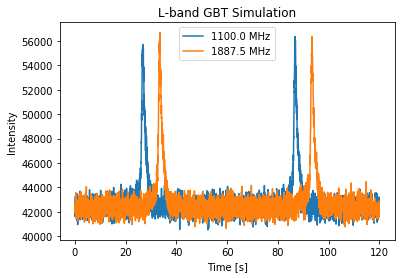

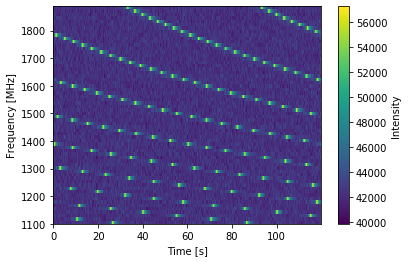

In [18]:
# We first plot the first two pulses in frequency-time space to show the undispersed pulses
time = np.linspace(0, obslen, len(signal_1713_GBT.data[0,:]))

# Since we know there are 2048 bins per pulse period, we can index the appropriate amount
plt.plot(time[:4096], signal_1713_GBT.data[0,:4096], label = signal_1713_GBT.dat_freq[0])
plt.plot(time[:4096], signal_1713_GBT.data[-1,:4096], label = signal_1713_GBT.dat_freq[-1])
plt.ylabel("Intensity")
plt.xlabel("Time [s]")
plt.legend(loc = 'best')
plt.title("L-band GBT Simulation")
plt.show()
plt.close()

# And the 2-D plot
plt.imshow(signal_1713_GBT.data[:,:4096], aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [min(time[:4096]), max(time[:4096]), signal_1713_GBT.dat_freq[0].value, signal_1713_GBT.dat_freq[-1].value])
plt.ylabel("Frequency [MHz]")
plt.xlabel("Time [s]")
plt.colorbar(label = "Intensity")
plt.show()
plt.close()

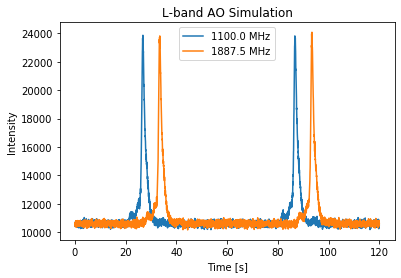

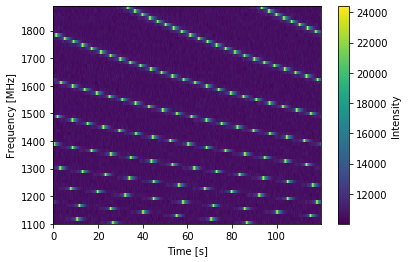

In [19]:
# Since we know there are 2048 bins per pulse period, we can index the appropriate amount
plt.plot(time[:4096], signal_1713_AO.data[0,:4096], label = signal_1713_AO.dat_freq[0])
plt.plot(time[:4096], signal_1713_AO.data[-1,:4096], label = signal_1713_AO.dat_freq[-1])
plt.ylabel("Intensity")
plt.xlabel("Time [s]")
plt.legend(loc = 'best')
plt.title("L-band AO Simulation")
plt.show()
plt.close()

# And the 2-D plot
plt.imshow(signal_1713_AO.data[:,:4096], aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [min(time[:4096]), max(time[:4096]), signal_1713_AO.dat_freq[0].value, signal_1713_AO.dat_freq[-1].value])
plt.ylabel("Frequency [MHz]")
plt.xlabel("Time [s]")
plt.colorbar(label = "Intensity")
plt.show()
plt.close()

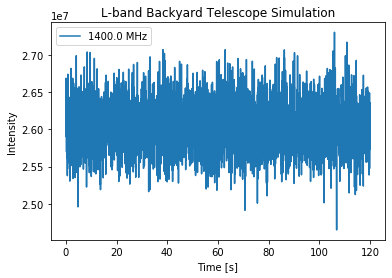

In [24]:
# Since we know there are 2048 bins per pulse period, we can index the appropriate amount
plt.plot(time[:4096], signal_1713_bkyd.data[0,:4096], label = "1400.0 MHz")
plt.ylabel("Intensity")
plt.xlabel("Time [s]")
plt.legend(loc = 'best')
plt.title("L-band Backyard Telescope Simulation")
plt.show()
plt.close()

We can see that, as expected, the Arecibo telescope is more sensitive than the GBT when observing over the same timescale. We can also see that even though the simulated pulsar here is easily visible with these large telescopes, our backyard telescope is not able to see the pulsar over the same amount of time, since the output is pure noise. The `PsrSigSim` can be used to determine the approximate sensitivity of an observation of a simulated pulsar with any given telescope that can be defined.